# Table of Contents:
* [Introduction](#Introduction)
 
 
* [1. Loading our Data](#1.-Loading-our-Data)
* [2. Creating Our CNN Model](#2.-Creating-Our-CNN-Model)
* [3. Training our Initial Model](#3.-Training-our-Initial-Model)
* [4. Evaluating Our Initial Model](#4.-Evaluating-Our-Initial-Model)
* [5. Modifying Our Model for Improvement](#5.-Modifying-Our-Model-for-Improvement)


* [Conclusion](#Conclusion)

# Introduction

In this notebook, we will take image data which has been collected in Notebook 1 and cleaned, sorted, and balanced in Notebook 2 in order to create a Convolutional Neural Network (CNN) model which predicts the classifications of skin lesions. In order to accomplish this task, we will need to load in our data through tensorflow and/or keras and create a CNN model which will set weights through training and, possibly, transfer learning. From this point, we will need to evaluate this model using our validation dataset and evaluate whether or not our model has performed well enough to consider it a successful model, or whether modifications must be made before considering it for making predictions on our testing dataset. Once we have a model which performs well enough to make testing predictions, we can further evaluate our model's performance using a number of metrics, particularly confusion matrices and classification reports.

First of all, let us import tools which might be useful throughout the process of creating and evaluating our CNN(s).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from IPython.display import Image, display
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import cv2
import tensorflow as tf
import keras

# 1. Loading our Data

Next, it is time to use tensorflow and keras tools to load our previously cleaned, split and manipulated image data into forms which will be usable for our modeling. In order to accomplish this, we will be utilizing `image_dataset_from_directory`, the documentaion of which is available [here](https://keras.io/api/preprocessing/image/).

In [2]:
# We have 2 classes we are trying to classify (for y1)
classes = 2

# They are colour images so they have 3 channels 
channels = 3

# We want to work with 20 images at a time (in each batch)
batch_size = 50

In [3]:
VGG_16 = VGG16(weights='imagenet', \
    include_top=False, pooling='max', classes = 2, input_shape=(75, 100, channels)) # our input shape should be the
    # same as the shape which we modified our images to previously.

In [4]:
for layer in VGG_16.layers:
    layer.trainable=False

In [5]:
ResNET_50 = ResNet50(include_top=False, input_shape=(75,100, channels),
                    pooling='avg',classes=2,
                     weights='imagenet')

In [6]:
for layer in ResNET_50.layers:
    layer.trainable=False

In [7]:
EfficientNET = EfficientNetB0(include_top=False, input_shape=(75,100, channels)
                     , classes=2,
                     weights='imagenet')

In [8]:
for layer in EfficientNET.layers:
    layer.trainable=False

In [9]:
batchSize = 50

In [10]:
image_size = (75,100)

In [11]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = 'skin_train',
                                                    image_size=(75, 100),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    subset = 'training',
                                                    label_mode = 'binary'
                                                   , seed = 42
                                                   , validation_split=15/85)

Found 14998 files belonging to 2 classes.
Using 12352 files for training.


To manually check on our training data after the manipulations to our image data which we performed, we are able to read our training data as a numpy iterator to generate batches of data which we can visualize. If one wishes, they may take as many batches as they would like until they are convinced that their training data has been correctly manipulated and loaded in.

In [12]:
train_data_iterator = train_data.as_numpy_iterator()

In [13]:
batch = train_data_iterator.next()

In [14]:
batch[0].shape

(50, 75, 100, 3)

C:\Users\danie\anaconda3\envs\deeplearning\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


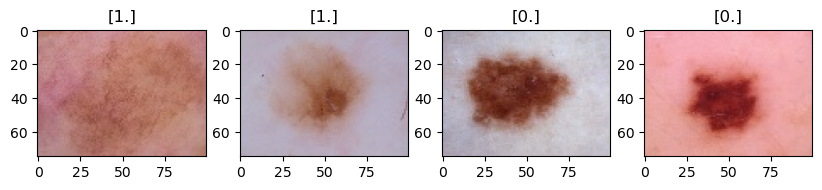

In [15]:
fig, ax = plt.subplots(ncols=4, figsize=(10,10))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

It is worth noting that these labels on our data, as are currently written with corressponding images, are not in a very human readable format. However, this will not be a problem for running our models, and so long as we are able to determine which label corresponds with which correct category for classification, there will be no issues moving forward.

In [16]:
#scaling our training data
train_data = train_data.map(lambda x,y: (x/255, y))

In [17]:
validation_data = tf.keras.preprocessing.image_dataset_from_directory(directory = 'skin_train',
                                                    image_size=(75, 100),
                                                    color_mode="rgb",
                                                    batch_size=batch_size,
                                                    shuffle=True, 
                                                    subset = 'validation',
                                                    label_mode = 'binary'
                                                   , seed = 42
                                                   , validation_split=15/85 )

Found 14998 files belonging to 2 classes.
Using 2646 files for validation.


In [18]:
#scaling our validation data
validation_data = validation_data.map(lambda x,y: (x/255,y))

In [19]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
                                                    directory = 'skin_test',
                                                    image_size=(75, 100),
                                                    batch_size = 1503,
                                                    color_mode="rgb",
                                                    shuffle=False,
                                                    label_mode = 'binary'
                                                   , seed = 42)

Found 1503 files belonging to 2 classes.


In [20]:
#scaling our testing data
test_data = test_data.map(lambda x,y: (x/255,y))

Now that we have our training, testing, and validation data loaded in, and corresponding folders of images sorted, it is time to consider our CNN models to see which of our options work best for our data. In evaluating which CNN model works best, we will evaluate using the actual values confered by the file locations, as our keras model will interpret these directories as having their corressponding actual values. Additionally, we will not only store within our model history performance metrics on the training dataset, but more importantly, on our validation dataset which has not been used to establish our model's weights.

In [21]:
logdir = 'logs'

In [22]:
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

# 2. Creating our CNN Model

Moving into this classification problem, our first attempted models should not use any of the transfer learning models which have been imported above for consideration. Instead, we should create our own layers which might yield possitive results on our dataset in terms of providing convolutions which will extract the greatest amount of valuable information for classification without overfitting to our training dataset.

For the creation of our model, may different kinds of CNN convolutions have been considered and implimented. The first of these layers, and arguably the simplest, is our Conv2D layer which has been passed over our image data. For our model, we have utilized 3 Conv2D layers utilized throughout the model which, as they each accept a kernel size of 3x3, [perform element-wise multiplication](https://www.databricks.com/glossary/convolutional-layer) on our images in order to create outputs which are smaller in size for our other layers to utilize.

Our next utilized convolutional layer is MaxPooling2D, a convolution which downsamples its inputs according to convolutions by taking the [maximum value over an input window](https://keras.io/api/layers/pooling_layers/max_pooling2d/). This could be particularly practical for our data, as many of our most crucial information within our input data is the skin lessions themselves, which will typically have higher values than the (lighter) skin around them. This layer can help to identify which portions of an image might be most crucial for classification.

One kind of CNN Layer which is utilized throughout our modeling for slightly different purposes are Dense layers. Dense layers are layers which will generate a [weighted average of the previous layer](https://towardsdatascience.com/introduction-to-convolutional-neural-network-cnn-de73f69c5b83) into a 1-dimensional array. One use of dense layers in our inital model is the last use of a dense layter in our model which, with the hyperparameter 4 chosing between 4 classes and an activation of softmax, informs our model to choose between our 4 categories before it returns so that our model will make a decision about which class it is predicting out of the number of classes which it has available.

Dropout layers, as discussed at [this link](https://www.baeldung.com/cs/ml-relu-dropout-layers), which is also the source of the visualization below, have proven to be highly effective in preventing model overfitting on this dataset. To begin with, we will utilize a single dropout layer. But, if the model seems to be overfitting with one dropout layer, we may wish to add additional dropout layers or to change our dropout perameter. First, however, we should consider how well our model seems to be overfitting with a single dropout layer.

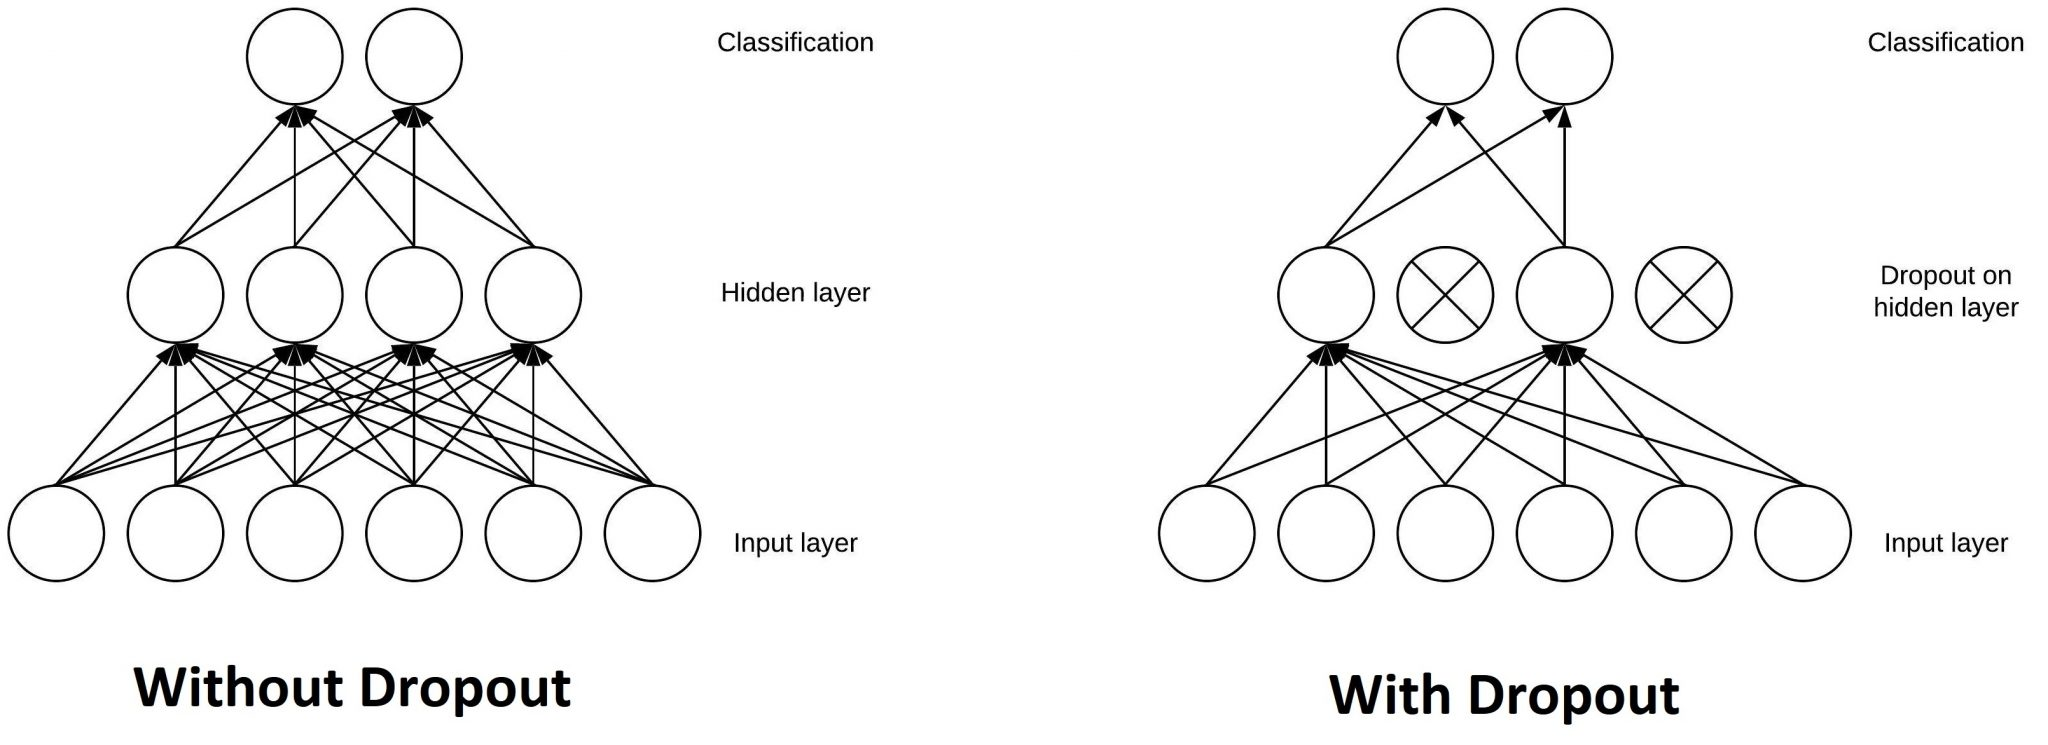

During the earliest instances of modeling on our data, dropout layers were not utilized at all. For these models, overfitting occured very frequently on our training dataset, and could usually be seen as a significant problem even within the first ten epochs of model training. This was significantly mitigated through the use of a dropout layer within the model, and can be further mitigated as nessassary through the utilization of additional dropout layers. For our first model in this notebook, only a single dropout layer will be used, but this decision will be revisited if it appears that our model continues to overfit.

In [37]:
input_shape = (75, 100, 3)
def prepare_model(Transfer=None):
    model = Sequential()
    if Transfer == 'VGG16':
        model.add(VGG_16)
    if Transfer == 'ResNET50':
        model.add(ResNET_50)
    if Transfer == 'EfficientNET':
        model.add(EfficientNET)
    model.add(Conv2D(63,kernel_size=(3,3),activation='relu', input_shape=input_shape))            
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    if Transfer==None:
        model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    print(model.summary())
    return model

In [38]:
model = prepare_model()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 73, 98, 63)        1764      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 49, 63)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 18, 24, 63)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 18, 24, 64)        36352     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 18, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 9, 12, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6912)             

In [26]:
model.reset_metrics

<bound method Model.reset_metrics of <tensorflow.python.keras.engine.sequential.Sequential object at 0x0000019AEBFE8C70>>

# 3. Training our Initial Model

Now that we have created our inital model for training, let us see how well it performs over 30 epochs on our training and validation data.

In [27]:
history = model.fit(train_data,
                    epochs=30,
                     validation_data= validation_data,
                     callbacks=[tensorboard_callback])

Epoch 1/30
  1/248 [..............................] - ETA: 0s - loss: 0.7001 - accuracy: 0.5400WARNING:tensorflow:From C:\Users\danie\anaconda3\envs\deeplearning\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
248/248 [==============================] - 90s 364ms/step - loss: 0.5903 - accuracy: 0.6843 - val_loss: 0.5282 - val_accuracy: 0.7695
Epoch 2/30
248/248 [==============================] - 52s 210ms/step - loss: 0.5149 - accuracy: 0.7585 - val_loss: 0.5292 - val_accuracy: 0.7540
Epoch 3/30
248/248 [==============================] - 52s 211ms/step - loss: 0.4952 - accuracy: 0.7600 - val_loss: 0.4654 - val_accuracy: 0.7702
Epoch 4/30
248/248 [==============================] - 53s 213ms/step - loss: 0.4854 - accuracy: 0.7668 - val_loss: 0.4730 - val_accuracy: 0.7721
Epoch 5/30
248/248 [================

# 4. Evaluating Our Initial Model

Now that we have run our initial model, it is time to evaluate which point saw the model perform best, particularly on our [validation set.](https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy) In order to accomplish this, we will create two graphs, one for model accuracy, and one for model loss, and plot both of these over all of our epochs for both the train data as well as the validation data. By utilizing both of these datasets in this way, we will be able to evaluate our model's learning from both of our datasets, but we will be able to tell if our model is overfitting based upon whether our training data begins to outperform our validation data.

In [28]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


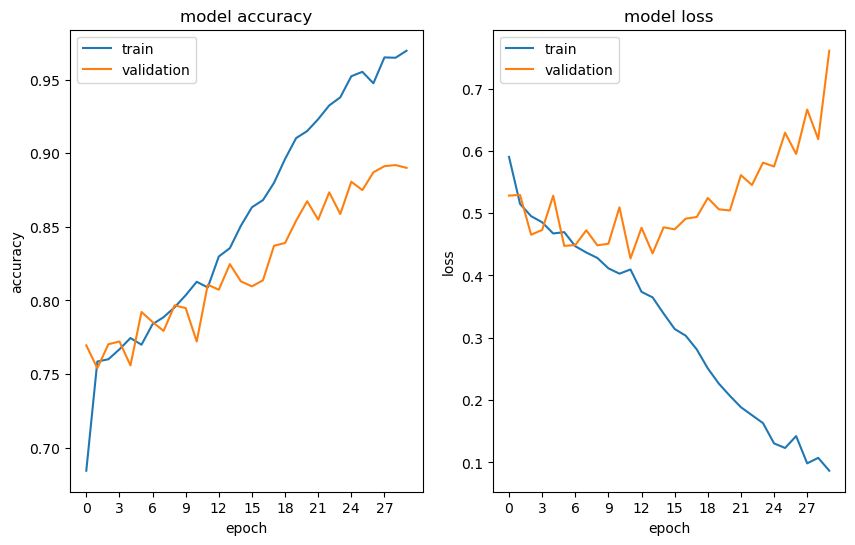

In [29]:
plt.subplots(1,2,figsize = (10,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xticks(np.arange(0,30,3))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xticks(np.arange(0,30,3))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

For our model, it appears that, starting at around epoch 15 or so, our validation loss began to rapidly increase, and our validation accuracy increased much slower than our accuracy on our training set. This means that our model was not improving in its performance on the validation set during this time despite some marginal improvements in our validation accuracy, and instead was heavily overfitting on our training data. We will now evaluate this model and make predictions based upon our test data to have a baseline for model accuracy moving forward, but it is key to note here that, based upon validation metrics alone, this model is not acceptable as a final model.

In [30]:
val_score = model.evaluate(validation_data)
print('Test loss:', val_score[0])
print('Test accuracy:', val_score[1])

53/53 [==============================] - 4s 66ms/step - loss: 0.7607 - accuracy: 0.8900
Test loss: 0.7607430219650269
Test accuracy: 0.8900226950645447


In [31]:
test_score = model.evaluate(test_data)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

1/1 [==============================] - 0s 0s/step - loss: 1.2313 - accuracy: 0.7871
Test loss: 1.2313357591629028
Test accuracy: 0.7870925068855286


In [33]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

In [34]:
np.sum(y)

201.0

In [35]:
yhat = yhat.flatten()

In [36]:
yhat = np.where(yhat > 0.5, 1, 0)

In [38]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [39]:
np.sum(yhat)

399

In [40]:
print(confusion_matrix(y, yhat))

[[1043  259]
 [  61  140]]


In [41]:
cf_matrix = confusion_matrix(y, yhat)
cf_matrix

array([[1043,  259],
       [  61,  140]], dtype=int64)

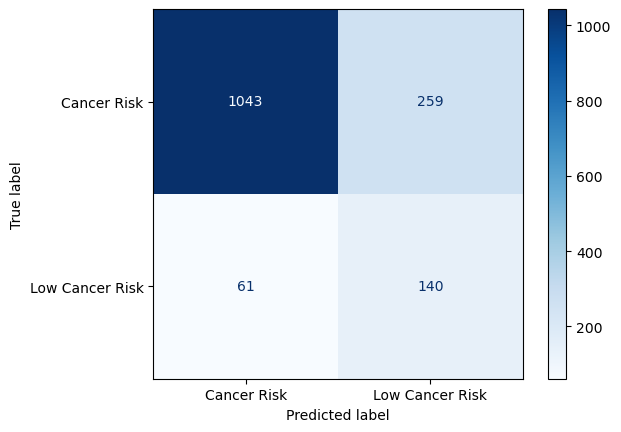

In [42]:
labels = ['Cancer Risk', 'Low Cancer Risk']
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [43]:
report = classification_report(y, yhat)
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.80      0.87      1302
         1.0       0.35      0.70      0.47       201

    accuracy                           0.79      1503
   macro avg       0.65      0.75      0.67      1503
weighted avg       0.87      0.79      0.81      1503



When viewing this classification report, it is worth noting that our keras model has chosen to classify `Cancer Risk` as 0 and `Low Cancer Risk` as 1. This is not an issue, but it does mean that, when viewing our classification report, we should consider our 0 variable as our possitive and our 1 variable as our negative. Aside from this, let us note our results from this first model, and carry it forward into the creation of new, better models.

# 5. Modifying Our Model for Improvement

Now, in order to create a model which might have a better performance on the testing dataset, we can use the information gathered in the running of our first model in order to see how our model might be improved. One point which is worth noting about our first model is that it does not seem to suggest that transfer learning is nessassary for our data, as the model seemed to have little trouble learning to adjust its weights effectively to the training data. In fact, the primary issue which seemed to occur for this model is that our weights overfit to the training data significantly. In order to mitigate this, let us run another model which only trains for 15 epochs, and see whether our metrics for this model improve.

In [34]:
model = prepare_model()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 73, 98, 63)        1764      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 49, 63)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 18, 24, 63)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 18, 24, 64)        36352     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6912)             

In [35]:
model.reset_metrics

<bound method Model.reset_metrics of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B303A89F70>>

In [36]:
history_2 = model.fit(train_data,
                    epochs=15,
                     validation_data= validation_data,
                     callbacks=[tensorboard_callback])

Epoch 1/15
248/248 [==============================] - 54s 219ms/step - loss: 0.5768 - accuracy: 0.7018 - val_loss: 0.5268 - val_accuracy: 0.7657
Epoch 2/15
248/248 [==============================] - 53s 214ms/step - loss: 0.5207 - accuracy: 0.7498 - val_loss: 0.5121 - val_accuracy: 0.7680
Epoch 3/15
248/248 [==============================] - 54s 219ms/step - loss: 0.5024 - accuracy: 0.7618 - val_loss: 0.5099 - val_accuracy: 0.7574
Epoch 4/15
248/248 [==============================] - 55s 222ms/step - loss: 0.4950 - accuracy: 0.7628 - val_loss: 0.4929 - val_accuracy: 0.7740
Epoch 5/15
248/248 [==============================] - 60s 242ms/step - loss: 0.4728 - accuracy: 0.7761 - val_loss: 0.4447 - val_accuracy: 0.7872
Epoch 6/15
248/248 [==============================] - 56s 227ms/step - loss: 0.4599 - accuracy: 0.7801 - val_loss: 0.4398 - val_accuracy: 0.7914
Epoch 7/15
248/248 [==============================] - 56s 224ms/step - loss: 0.4438 - accuracy: 0.7935 - val_loss: 0.4285 - val_ac

In [ ]:
plt.subplots(1,2,figsize = (10,6))

plt.subplot(1,2,1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xticks(np.arange(0,15,3))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xticks(np.arange(0,15,3))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [61]:
val_score = model.evaluate(validation_data)
print('Test loss:', val_score[0])
print('Test accuracy:', val_score[1])

53/53 [==============================] - 4s 71ms/step - loss: 0.3998 - accuracy: 0.8125
Test loss: 0.39977145195007324
Test accuracy: 0.8125472664833069


For our model, it appears that, starting at around epoch 20 or so, our validation loss began to rapidly increase, and never fully came back down. This means that our model was not improving in its performance on the validation set during this time despite some marginal improvements in our validation accuracy. Before we use our model to make prediction, it might be wise to first see 

In [62]:
test_score = model.evaluate(test_data)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

1/1 [==============================] - 0s 2ms/step - loss: 0.4489 - accuracy: 0.7838
Test loss: 0.4488818645477295
Test accuracy: 0.7837657928466797


In [64]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

In [65]:
np.sum(yhat)

444.33203

In [66]:
yhat = yhat.flatten()

In [67]:
yhat = np.where(yhat > 0.5, 1, 0)

In [69]:
print(history_2.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [70]:
print(confusion_matrix(y, yhat))

[[1023  279]
 [  46  155]]


In [71]:
cf_matrix = confusion_matrix(y, yhat)
cf_matrix

array([[1023,  279],
       [  46,  155]], dtype=int64)

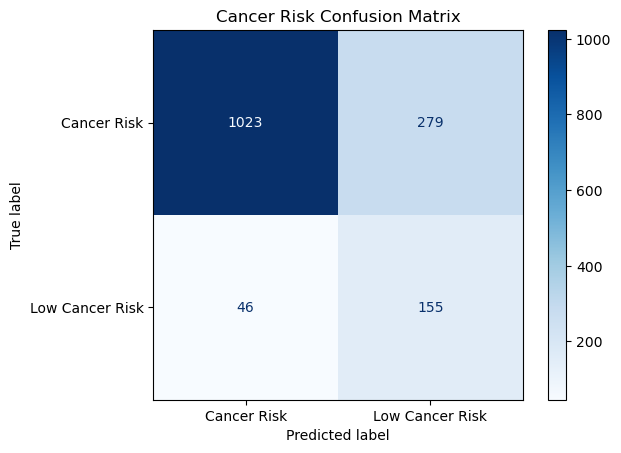

In [77]:
labels = ['Cancer Risk', 'Low Cancer Risk']
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Cancer Risk Confusion Matrix")
plt.show()

In [73]:
report = classification_report(y, yhat)
print(report)

              precision    recall  f1-score   support

         0.0       0.96      0.79      0.86      1302
         1.0       0.36      0.77      0.49       201

    accuracy                           0.78      1503
   macro avg       0.66      0.78      0.68      1503
weighted avg       0.88      0.78      0.81      1503



In [74]:
model.save_weights("model.binary_preliminary")

In [75]:
model.save("Capstone Binary Preliminary")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Capstone Binary Preliminary\assets


It appears that, while our model got better at predicting our negative class, it actually saw a slight drop in performance on our positive class. While overall, this model is an acceptable preliminary model with which to compare further results, there is still much room for improvement.

Another idea for the improvement of model performance would be to add additional dropout layers such that our model will not overfit to our training data. With these changes, our model should also be able to train for longer without overfitting, meaning that it might be able to make more accurate predictions thanks to this additional training. For our next model, let us see how well adding dropout layers to our `prepare_model` function improves model performance, particularly over a greater number of epochs.

In [27]:
input_shape = (75, 100, 3)
def prepare_model(Transfer=None):
    model = Sequential()
    model.add(Conv2D(63,kernel_size=(3,3),activation='relu', input_shape=input_shape))            
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',padding = 'Same', input_shape=input_shape))             
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5)) # adding an additional dropout layer here to prevent overfitting
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))# adding an additional dropout layer here to prevent overfitting
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss="binary_crossentropy",optimizer="adam",metrics=['accuracy'])
    print(model.summary())
    return model

In [28]:
model = prepare_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 73, 98, 63)        1764      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 49, 63)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 24, 63)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 24, 64)        36352     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 24, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 12, 64)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 12, 64)        

In [29]:
model.reset_metrics

<bound method Model.reset_metrics of <tensorflow.python.keras.engine.sequential.Sequential object at 0x000001B3606883A0>>

In [30]:
history_3 = model.fit(train_data,
                    epochs=60,
                     validation_data= validation_data,
                     callbacks=[tensorboard_callback])

Epoch 1/60
248/248 [==============================] - 57s 229ms/step - loss: 0.5924 - accuracy: 0.6874 - val_loss: 0.5595 - val_accuracy: 0.7120
Epoch 2/60
248/248 [==============================] - 59s 239ms/step - loss: 0.5236 - accuracy: 0.7528 - val_loss: 0.4884 - val_accuracy: 0.7706
Epoch 3/60
248/248 [==============================] - 57s 230ms/step - loss: 0.5113 - accuracy: 0.7540 - val_loss: 0.4843 - val_accuracy: 0.7695
Epoch 4/60
248/248 [==============================] - 59s 240ms/step - loss: 0.4964 - accuracy: 0.7579 - val_loss: 0.4703 - val_accuracy: 0.7736
Epoch 5/60
248/248 [==============================] - 69s 280ms/step - loss: 0.4932 - accuracy: 0.7630 - val_loss: 0.4626 - val_accuracy: 0.7770
Epoch 6/60
248/248 [==============================] - 60s 243ms/step - loss: 0.4809 - accuracy: 0.7683 - val_loss: 0.4607 - val_accuracy: 0.7782
Epoch 7/60
248/248 [==============================] - 72s 288ms/step - loss: 0.4759 - accuracy: 0.7755 - val_loss: 0.4513 - val_ac

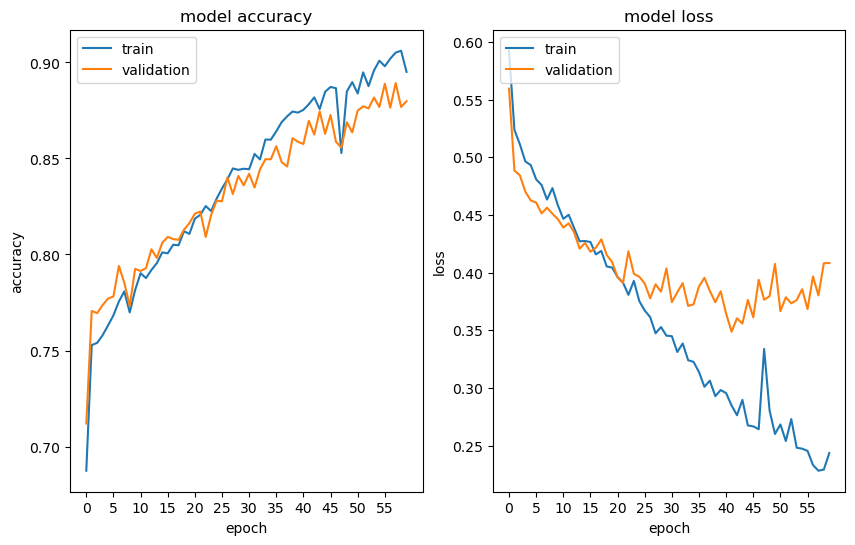

In [32]:
plt.subplots(1,2,figsize = (10,6))

plt.subplot(1,2,1)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xticks(np.arange(0,60,5))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# "Loss"
plt.subplot(1,2,2)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xticks(np.arange(0,60,5))
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [83]:
val_score = model.evaluate(validation_data)
print('Test loss:', val_score[0])
print('Test accuracy:', val_score[1])

53/53 [==============================] - 3s 65ms/step - loss: 0.4242 - accuracy: 0.8723
Test loss: 0.4241757094860077
Test accuracy: 0.8722600340843201


In [84]:
test_score = model.evaluate(test_data)
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

1/1 [==============================] - 0s 0s/step - loss: 0.4889 - accuracy: 0.8330
Test loss: 0.4889250695705414
Test accuracy: 0.833000659942627


In [86]:
for batch in test_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)

In [87]:
np.sum(yhat)

357.27264

In [88]:
yhat = yhat.flatten()

In [89]:
yhat = np.where(yhat > 0.5, 1, 0)

In [91]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [92]:
print(confusion_matrix(y, yhat))

[[1104  198]
 [  53  148]]


In [93]:
cf_matrix = confusion_matrix(y, yhat)
cf_matrix

array([[1104,  198],
       [  53,  148]], dtype=int64)

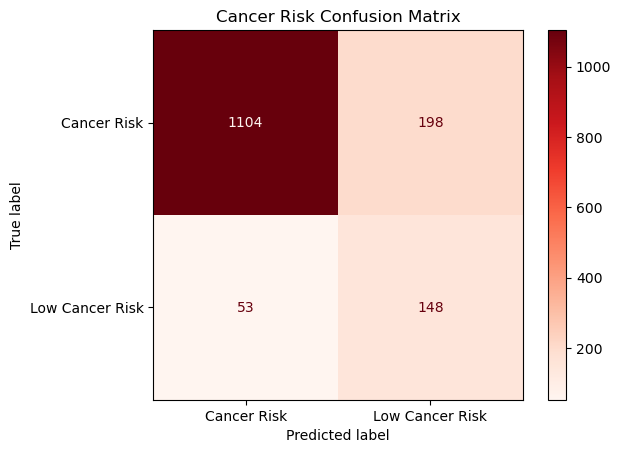

In [106]:
# for this final confusion matrix, I have decided to change the color scheme so that
# it will have a greater contrast against the confusion matrix of our categorical model
labels = ['High Cancer Risk', 'Low Cancer Risk']
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=labels)
disp.plot(cmap=plt.cm.Reds)
plt.title("Cancer Risk Confusion Matrix")
plt.show()

In [95]:
report = classification_report(y, yhat)
print(report)

              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90      1302
         1.0       0.43      0.74      0.54       201

    accuracy                           0.83      1503
   macro avg       0.69      0.79      0.72      1503
weighted avg       0.88      0.83      0.85      1503



This model, having run over 60 epochs, clearly has the best performance out of all of our models considered so far. Our model reached an overall accuracy of ~83.3%. Additionally, our model's weighted average scores performed quite admirably, with a precision of 0.88, a recall of 0.83, and an f1-score of 0.85. That having been said, there is still more room for potential improvement, as this final model actually has slightly worse performance than our very first model at accurately labeling `Low Cancer Risk` images. While this serves as a reminder of how our model might continue to be improved, though, this model still performed quite well on our metrics, particularly at identifying our positive class, `Cancer Risk`.

In [96]:
model.save_weights("model.binary_final")

In [97]:
model.save("Capstone Binary Final")

INFO:tensorflow:Assets written to: Capstone Binary Final\assets


# Conclusion

In this notebook, we utilized image data which has been balanced and partitions between our training/validation sets and our testing set to build three CNN models, each performing better on our data than the last. The possibility of using transfer learning to build our models was considered, but discarded as it became clear that our training data was sufficient for setting model weights such that our model could accurately predict our binary categories. While our final model performed quite well on the dataset, there are always more opportunities for improvement, and moving forward, we should continue to look for new, innovative ways to ensure that our next model itteration is better than the last